In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Lab 1: Text Corpora and Language Modelling

This lab is meant to help you get familiar with some language data, and use this data to estimate N-gram language models

First you will use the **Penn Treebank**, which is a collection of newspaper articles from the newspaper 
The Wall Street Journal. The idea is to examine the data and notice interesting properties. This will not take more than a few lines of code.

Then you will use a corpus consisting of **TedX** talks. This you will use to estimate an **N-gram language model** for different orders of N, and use this this for some tasks.

The datasets are on blackboard under course materials. Download the zip and make sure to put the files in the same directory as the notebook.

### Rules
* The lab exercises should be made in **groups of two people**.

* The deadline is **Tuesday 7 nov 16:59**.

* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be `lab1_lastname1_lastname2.ipynb`, so for example `lab1_Jurafsky_Martin.ipynb`.

* The notebook is graded on a scale of **0-10**. The number of points for each question is indicated in parantheses. 

* The questions marked **optional** are not graded; they are an additional challenge for those interested in going the extra mile. 

Notes on implementation:

* You should **write your code and answers in this iPython Notebook** (see http://ipython.org/notebook.html for reference material). If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `# YOUR CODE HERE` comment.
    
    * For theoretical question, put your solution in the YOUR ANSWER HERE cell.
    
* Test your code and **make sure we can run your notebook**

# 1. Penn treebank

## Exercise 1.1 (40 points, 5 points per subquestion )

You are provided with a corpus containing words with their Part-of-Speech tags (POS-tags for short). The format is
**word|POS** (one sentence per line) and the file name is **sec02-22.gold.tagged**. This data is extracted from Sections 02-22 from the Penn Treebank: these sections are most commonly used for training statistical models like POS-taggers and parsers.

**[Hint]** **Figure 10.1** in chapter 10 of Jurafsky and Martin (see [here](https://web.stanford.edu/~jurafsky/slp3/10.pdf)) holds a summary of the 45 POS-tags used in the Penn Treebank tagset together with their meaning and some examples. (If you are keen on learning more about the word-classes represented POS-tags and their definitions you can do a litle reading ahead for next week and already have a look at section 10.1 of the same chapter).

**[Hint]** the Python library [collections](https://docs.python.org/2/library/collections.html) has an object called `Counter` which will come in handy for this exercise.

**(a)** How large is the corpus? (i.e. how **many tokens**). And what is the size of the **vocabulary** used in this corpus? 

Estimate the vocabulary size both by **lowercasing** all the words as well as by leaving the words in their **original orthography**. What is an advantage of lowercasing all the words in your corpus? What is a notable downside? **Give examples.**

In [44]:
import os
import string
from collections import Counter, defaultdict, OrderedDict, deque

path = os.path.join("data","sec02-21.gold.tagged")
f = open(path,"r")

counter_orig = Counter()
counter_lower = Counter()
counter_pos = Counter()
counter_wordPOS = Counter()

count_diff = 0

for line in f:
    parts = line.strip().split(" ")
    
    for part in parts:
        
        # Word|pos combinations
        counter_wordPOS[part] += 1            
        token, pos = part.split("|", 1)
        
        counter_pos[pos] += 1
        
        # Ignore punctuation
#         if token in string.punctuation:
#             continue
        
        # count original tokens
        counter_orig[token]+=1

        # count lowercased tokens
        counter_lower[token.lower()] += 1
f.close()
print("Number of tokens")
print("Original:", sum(counter_orig.values()))
print("Lowercase:", sum(counter_lower.values()))
print()
print("Number of word types")
print("Original:", len(list(counter_orig)))
print("Lowercase:", len(list(counter_lower)))

Number of tokens
Original: 929552
Lowercase: 929552

Number of word types
Original: 44210
Lowercase: 39384


#### Number of tokens

Original: 929552

Lowercase: 929552

#### Number of word types

Original: 44210

Lowercase: 39384

#### Explanation

The advantage of lowercasing all the tokens is that you no longer count words at the beginning of a sentence as seperate words. But, by doing this you also lose lowercase given names and places and risk pooling them with the regular words.

An example of the advantage:
"This morning I drank this cup of coffee." has a count of 1 for "This" and of 1 for "this". We would like to add these two together, as they are the same word.

Disadvantage:
In the sentence "In college, George Bush peed in a bush." "Bush" and "bush" will be grouped together.

------
For the rest of this exercise you should use the **original orthography** of the data when answering the questions.

------


**(b)** Plot a graph of word frequency versus rank of a word, in this corpus. Does this corpus obey **Zipf’s law**?

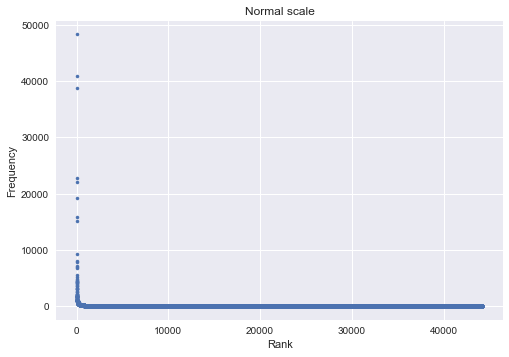

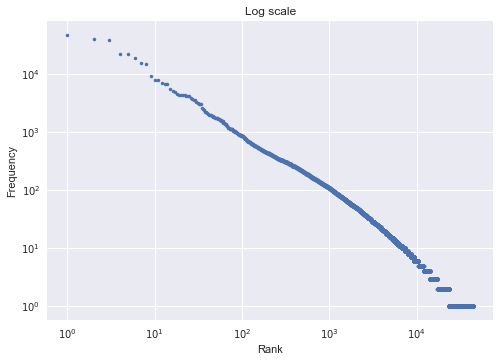

In [150]:
frequencies = sorted(counter_orig.values(), reverse=True)
ranks = range(1, len(frequencies) + 1)

# Plot rank to frequency
fig1, ax1 = plt.subplots()
ax1.plot(ranks, frequencies, '.')
ax1.set_title("Normal scale")

# Plot the same in log-scale
fig2, ax2 = plt.subplots()
ax2.loglog(ranks, frequencies, '.')
ax2.set_title("Log scale")

# Label axis
for ax in [ax1, ax2]:
    ax.set_xlabel("Rank")
    ax.set_ylabel("Frequency")

In [4]:
# Check for zipf's law f*r=k
for i in range(0, len(frequencies), 1000):
    print(np.log(ranks[i]) + np.log(frequencies[i]))

10.7853938575
11.6001026615
11.5332279673
11.4406880499
11.3388220466
11.2899818937
11.1845880508
11.156393368
11.0667633545
11.0510011103
11.0021998362
10.9151793692
10.7790396198
10.8590759177
10.9331783957
10.7144844332
10.7790187879
10.8396397335
10.4913297715
10.5453940689
10.5966847318
10.6454725152
10.6919903664
10.7364401528
10.0858507751
10.1266711031
10.1658902778
10.2036291813
10.2399955028
10.2750855911
10.3089859934
10.341774741
10.3735224313
10.404293143
10.4341452149
10.4631319115
10.4913019948
10.5187002183
10.5453677542
10.5713425658
10.5966597328
10.6213517356
10.6454487065
10.6689786502
10.6919676399


It looks like the corpus obeys Zipf's law. As you can see in the plots, the top ranked word types occur extremely more often than most of the others. This result can be summarized by `log(rank) + log(frequency) ~= constant`. You can see from the sample above that this is indeed the case for this corpus. 

So, yes. This corpus obeys Zipf's law.

**(c)** What are the **20 most common words** in the corpus and how often do they occur? What is the 50th most common word, the 100th and the 1000th and how often do they occur?

In [5]:
ordered_words = sorted(counter_orig.items(), key=lambda t: t[1], reverse=True)

print("Top 20:")
for rank in list(range(1,21)) + [50, 100, 1000]:
    suffix = "th"
    
    # Exceptions for podium places
    if rank == 1: suffix = "st"
    if rank == 2: suffix = "nd"
    if rank == 3: suffix = "rd"
    
    print(str(rank) + suffix + ":", ordered_words[rank - 1][0], "->", ordered_words[rank - 1][1])
    if rank == 20: 
        print()

Top 20:
1st: , -> 48310
2nd: the -> 40839
3rd: . -> 38798
4th: of -> 22782
5th: to -> 22056
6th: a -> 19171
7th: and -> 15906
8th: in -> 15085
9th: 's -> 9249
10th: that -> 7951
11th: for -> 7912
12th: $ -> 7125
13th: is -> 6893
14th: The -> 6791
15th: said -> 5597
16th: on -> 5112
17th: % -> 4871
18th: it -> 4639
19th: by -> 4450
20th: from -> 4437

50th: had -> 1755
100th: A -> 860
1000th: man -> 109


**(d)** How many different Part-of-speech tags are present in the corpus?

In [6]:
print("Unique POS-tags:", len(list(counter_pos)))
print("Including punctuation")

Unique POS-tags: 48
Including punctuation


**(e)** Print a list of the **10 most commonly occurring POS tags** in the data. For each of these POS tags, what are the **3 most common words** that belong to that class?

In [7]:
# Needed a dict with a set as value
unique_wordPOS_combinations = defaultdict(set)

for keys,values in counter_wordPOS.items():
    word,POS = keys.split("|", 1)
    wordpos = (word, POS)
    unique_wordPOS_combinations[word].add(POS)

In [8]:
ordered_pos = sorted(counter_pos.items(), key=lambda t: t[1], reverse=True)
top_pos_with_top_words = OrderedDict()

# https://stackoverflow.com/questions/35791051/better-way-to-check-if-all-lists-in-a-list-are-the-same-length
def stop_looking(found_words):
    return all(len(l) == 3 for l in found_words)

# Create dictionary with 10 most frequent POS-tags
for i in range(10):
    top_pos_with_top_words[ordered_pos[i][0]] = []

# Start going through all the words in order of frequency
for word, _ in ordered_words:
    POS_tags = unique_wordPOS_combinations[word]
    
    # Iterate over the top 10 tags
    for tag in top_pos_with_top_words.keys():
        top_words = top_pos_with_top_words[tag]
        
        # If this word has the tag and the tag still has less than 3 words assigned
        if tag in POS_tags and len(top_words) < 3:
            top_words.append(word)
    
    # Stop looping over the wordlist as soon as all 10 tags have 3 words assinged
    if stop_looking(top_pos_with_top_words.values()):
        break
            
for i, kv in enumerate(top_pos_with_top_words.items()):
    print(i+1, kv[0], "with top words:", kv[1])

1 NN with top words: ['the', 'that', '%']
2 IN with top words: ['of', 'to', 'and']
3 NNP with top words: ['the', 'a', "'s"]
4 DT with top words: ['the', 'a', 'that']
5 JJ with top words: ['the', '%', 'as']
6 NNS with top words: ["'s", 'is', 'years']
7 , with top words: [',', 'an', '2']
8 . with top words: ['.', '?', '!']
9 CD with top words: ['million', 'billion', 'one']
10 RB with top words: ['of', 'and', 'in']


**(f)** A single word may have several POS-tags. For example, *record* can be a both a **noun** *(buy a record)* or a **verb** *(record a lecture)*. This make POS-tags extremely useful for **disambiguation**.

What percentage of the words in the vocabulary is **ambiguous**? (i.e. have more than one POS tag?) What are the 10 most frequent combinations of POS tags in the case of ambitguity? Which words are **most ambiguous**? Give some of them.

In [254]:
# Dictionary of ambiguous words and their tags
ambiguous = {}
for words, pos in unique_wordPOS_combinations.items():
    if len(pos)>1:
        ambiguous[words]=pos

# Percentage of ambiguous words
vocabularysize =len(list(counter_orig.values()))
print((len(ambiguous)/(vocabularysize))*100, '% of the vocabulary is ambiguous')


print()

# Most Ambiguous combinations
amb_sorted = OrderedDict(sorted(ambiguous.items(), key=lambda t: len(t[1]), reverse =True))
print("The top 10 most ambiguous words-postag combinations are:")
for w, t in list(amb_sorted.items())[:10]:
    print(w+", with the tags: ", t)
    
print()
    
    
# Most ambiguous words 
print("The most ambiguous words, all with 7 distinct tags, are: ")
for w, t in list(amb_sorted.items())[:4]:
    print(w+", with the tags: ", t)


13.469803211942999 % of the vocabulary is ambiguous

The top 10 most ambiguous words-postag combinations are:
set, with the tags:  {'VBZ', 'VBN', 'NN', 'VBP', 'VB', 'JJ', 'VBD'}
many, with the tags:  {'RB', 'NP', 'NN', 'PDT', 'DT', 'VB', 'JJ'}
open, with the tags:  {'RB', 'RP', 'VBZ', 'NN', 'VBP', 'VB', 'JJ'}
down, with the tags:  {'RB', 'RP', 'RBR', 'IN', 'NN', 'VBP', 'JJ'}
in, with the tags:  {'RB', 'RP', 'IN', 'RBR', 'FW', 'CC'}
that, with the tags:  {'RB', 'IN', 'NN', 'VBP', 'DT', 'WDT'}
own, with the tags:  {'VBZ', 'VBN', 'NN', 'VBP', 'VB', 'JJ'}
cut, with the tags:  {'VBN', 'NN', 'VBP', 'VB', 'JJ', 'VBD'}
point, with the tags:  {'VBZ', 'VBN', 'NN', 'VBP', 'VB', 'JJ'}
left, with the tags:  {'RB', 'VBN', 'NN', 'VB', 'JJ', 'VBD'}

The most ambiguous words, all with 7 distinct tags, are: 
set, with the tags:  {'VBZ', 'VBN', 'NN', 'VBP', 'VB', 'JJ', 'VBD'}
many, with the tags:  {'RB', 'NP', 'NN', 'PDT', 'DT', 'VB', 'JJ'}
open, with the tags:  {'RB', 'RP', 'VBZ', 'NN', 'VBP', 'VB', 'JJ

**(g)**  Print some of these words with their multiple POS-tags. Do you **understand the ambiguity**? Use figure 10.1 mentioned above to interpret the POS-tags.

ANSWER:

The top 10 most ambiguous words are printed above. The pos tags of  one of the most ambiguous word 'set' are:

- NN =  noun, sing. or mass 
- JJ = adjective 
- VBD = verb past tense
- VBN =  verb past participle
- VBZ =  verb 3sg pres 
- VBP = verb non-3sg pres
- VB = verb base form 

This word has appeared in the corpus in all these different forms of parts of speach.

**(h)** Ambiguous words do not account for a great percentage of the vocabulary. Yet they are among the most commonly occuring words of the English language. What **percentage of the dataset is ambiguous**?

In [10]:
corpussize = sum(counter_orig.values())
print('Of the dataset '+str((sum(counter_orig[i] for i in ambiguous) / corpussize) * 100)+'% is ambiguous.')

Of the dataset 55.079005800643756% is ambiguous.


## Exercise 1.2 (10 points, 5 per subquestion)

You are also provided with another file called **sec00.gold.tagged**. 
Section 00 of the Penn Treebank is typically used as development data.

**(a)** How many **unseen words** are present in the development data (i.e., words that have not occurred in the training data)?

In [11]:
path = os.path.join("data","sec00.gold.tagged")
file = open(path,"r")

counter_develop_token = Counter()
counter_develop_pos = Counter()
develop_tokens = []
develop_pos = []

for lin in file:
    lines = lin.strip().split(" ")
    
    for lin in lines:
        token, pos = lin.split("|", 1)
        
        develop_tokens.append(token)
        develop_pos.append(pos)
        
file.close()

vocabulary = list(counter_orig)
unseen_tokens = [(token, pos) for token, pos in zip(develop_tokens, develop_pos) if not token in vocabulary]
unseen_pos = Counter(p[1] for p in unseen_tokens)





print("The size of the vocabulary of the training dataset is:", len(vocabulary),"\n The size of the development data vocabulary is: ", len(develop_tokens),"\n And there are "+str(len(unseen_tokens))+" unseen words")


The size of the vocabulary of the training dataset is: 44210 
 The size of the development data vocabulary is:  45422 
 And there are 1728 unseen words


**(b)** What are the three **POS tag categories** that the most **unseen words** belong to?

In [12]:
for pos, freq in unseen_pos.most_common(3):
    print(str(pos)+": "+str(freq))



NNP: 815
JJ: 258
NN: 210


# 2. Language Models

This part of the lab will be covered in the Wednesday lecture. If you have prior exposure to NLP, go ahead and finish this part! If you don't, start anyway, and this part will be clear after the lecture. 

Reference **chapter 4** of J&M *Language Modeling with N-Grams*. 

----------

Models that assign **probabilities** to **sequences of words** are called language **language
modelels** or **LMs**. The simplest model that assigns probabilities to sentences and sequences of words is the **N-gram** model.

Recall that an *N*-gram language model uses **conditional probabilities** of the form
    
$$P(w_k \mid w_{k-N+1} \dots w_{k-1})$$

to **approximate** the full **joint probability**

$$P(w_1 \dots w_n)$$

of a sequence of words $w_1 \dots w_n$.

The easiest way of obtaining estimates for the probabilities $P(w_k \mid w_{k-N+1} \dots w_{k-1})$ is to use the **maximum likelihood estimate** or **MLE**, a widely used statistical estimation method ([read more]((https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)). You count and normalize:

$$P_{MLE}(w_k \mid w_{k-N+1} \dots w_{k-1}) = \frac{C(w_{k-N+1} \dots w_{k-1} w_k)}{C(w_{k-N+1} \dots w_{k-1})}.$$


## Exercise 2.1 (25 points)

**(a) ** Complete the function `train_ngram` so that you can train a count-based $N$-gram language model on the data found in `data/ted-train.txt` and train this for $N=2,3,4$. **15 points**

**(b) ** Extend the function above so that it accepts a parameter `k` for optional add-$k$ smoothing. **10 points**

**[Datastructure hint]** If you store the smoothed language in a naive manner (that is, to store *all* the numbers separately) your datastructure will get huge! If $V$ is the vocabulary then the smoothed bigram model assigns probabilities to $|V|^2$ entries. If $|V|$ is around 80k, the naive way requires you to store more than 64 billion floats. Yet almost all of these are actually just $P(w_n|w_{n-1}) = \frac{k}{N + k|V|}$, with $k$ the value with which you smooth and $N=C(w_{n-1})$. Think about how you use this fact to make your model work in practice.

**[Python hint]** The `collections` library has another useful datastructure: the `defaultdict`. Some example uses:

In [13]:
from collections import defaultdict

d = defaultdict(float)
d["new key"]

0.0

Compare that to an ordinary dictionary:

In [14]:
d = dict()
d["new key"]

KeyError: 'new key'

Other datatypes as `default_factory`:

In [17]:
d = defaultdict(int)
d["new key"]

0

In [18]:
d = defaultdict(list)
d["new key"]

[]

Converting an already existing `dict`:

In [19]:
d1 = {k: "value" for k in range(1, 11)}
d = defaultdict(float, d1) # convert it to a defaultdict
print(d[5])
print(d[100])

value
0.0


This doesn't work:

In [20]:
d = defaultdict(10)

TypeError: first argument must be callable or None

Use a `lambda` to make the number `10` `callable`":

In [21]:
d = defaultdict(lambda: 10)
d["new key"]

10

In [22]:
d = defaultdict(lambda: defaultdict(float))
d["new key"]

defaultdict(float, {})

Clever use of a `defaultdict` can be the solution to the problem of data-storing in a smoothing $N$-gram pointed out above:
    
    ngram = defaultdict(lambda: k/(N+kV), ngram)

The following function is given:

In [45]:
train_file = os.path.join("data","ted-train.txt")

def read(fname, max_lines=np.inf):
    """
    Reads in the data in fname and returns it as
    one long list of words. Also returns a vocabulary in
    the form of a word2index and index2word dictionary.
    """
    data = []
    # w2i will automatically keep a counter to asign to new words
    w2i = defaultdict(lambda: len(w2i))
    i2w = dict()
    start = "<s>"
    end = "</s>"
    
    with open(fname, "r", encoding = 'utf8') as fh:
        for k, line in enumerate(fh):
            if k > max_lines:
                break
            words = line.strip().split()
            # assign an index to each word
            for w in words:
                i2w[w2i[w]] = w # trick
            
            sent = [start] + words + [end]
            data.append(sent)

    return data, w2i, i2w

In [275]:
from copy import deepcopy

def train_ngram(data, N, k=0):
    """
    Trains an n-gram language model with optional add-k smoothing
    and additionaly returns the unigram model
    
    :param data: text-data as returned by read
    :param N: (N>1) the order of the ngram e.g. N=2 gives a bigram
    :param k: optional add-k smoothing
    :returns: ngram and unigram
    """
    
    # data
    flat_data = [word for sent in data for word in sent]
    
    # initialize ngram and unigram
    unigram = defaultdict(float, Counter(flat_data)) # default prob is 0.0
    ngram = defaultdict(Counter) # ngram[history][word] = #(history,word)
    
    # vocabulary size and corpus size
    vocabulary_size = len(list(unigram))
    corpus_size = len(flat_data)
    
    # init history counter object
    history_count = Counter()
    
    # history is a fixed length list which fills FIFO from right to left using .append()
   
    current_history = deque((N-1)*["<s>"], N-1)

    # Create counts ngram
    for i, word in enumerate(flat_data):
        # Also prepend every sentence with as many <s> 's as needed to be able to use a ngram for the first word
        if word == '<s>':
            current_history = deque((N-1)*["<s>"], N-1)
            
        curr_history_string = ' '.join(current_history)

        history_count[curr_history_string] += 1

        # Update count for (history, word)
        ngram[curr_history_string][word] += 1

        # Add word to history
        current_history.append(word)
    
    # Needed for 2.3
    rawcounts = deepcopy(ngram)

    # no smoothing
    if k== 0:
    
        # Create probabilties unigram
        for word in list(unigram):
            unigram[word] = (unigram[word] / corpus_size)

        # Create probabilities ngram
        for i, history in enumerate(list(ngram)):
            for word in list(ngram[history]):

                ngram[history][word] = (ngram[history][word] / history_count[history])
   
    # if smoothing
    else:
        # unigram probabilities
        for word, frequency in unigram.items():
            unigram[word] = (k+frequency)/(corpus_size+k*vocabulary_size)
            
        # ngram probabilites
        for history, counterobject in ngram.items():
            
            # The total count of every history is different, that needs to be taken into account
            count_history = sum(counterobject.values())
            
            # For every possible word given this history, the default is a smoothed value
            word_def_dict = defaultdict(lambda: k/(count_history+(k*vocabulary_size)))
            
            # For the words that do exist given this history
            for word, frequency in counterobject.items():
                word_def_dict[word] = (frequency+k)/(count_history+(k*vocabulary_size))
            
            # Add all words (seen and unseen), to the ngram history
            ngram[history] = word_def_dict


    return ngram, unigram, rawcounts

In [ ]:
# data, w2i, i2w = read(train_file)
bigram, unigram, rawcountsbi = train_ngram(data, N=2, k=0)
trigram, unigram, rawcountstri = train_ngram(data, N=3, k=0)
quadgram, unigram, rawcountsquad = train_ngram(data, N=4, k=0)


In [ ]:
smooth_bigram, smooth_unigram, _ = train_ngram(data, N=2, k=1)

## Exercise 2.2 (5 points)

You can use an *N*-gram language model to **generate text**. The higher the order *N* the better your model will be able to catch the long-range dependecies that occur in actual sentences and the better your changes are at generating sensible text. But beware: **sparsity** of language data will quickly cause your model to reproduce entire lines from your training data; in such cases only one $w_k$ was observed for the histories $w_{k-N+1}\dots w_{k-1}$ in the entire training-set.

**Complete** the function `generate_sent`. It takes a language model `lm` and an order `N` and should generate a sentence by **sampling** from the language model.

**[Hint]** You can use the method of [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to generate a sample from a **categorical distribution**, $p_1\dots p_k$ such that $p_i \geq 0$ and $\sum_{i=1}^k p_i = 1$, as follows:

In [48]:
from random import random

P = [0.2,0.5,0.2,0.1]

def sample(P):
    u = random() # uniformly random number between 0 and 1
    p = 0
    for i, p_i in enumerate(P):
        
        # swapped the lines to get rid of None and align the output with the list indices
        p += p_i
        if p > u: 
            return i # the first i s.t. p1 + ... + pi > u
        
        
print(sample(P))

print(Counter([sample(P) for i in range(1000)])) # check to see if the law of large numbers is still true

1
Counter({1: 503, 0: 203, 2: 185, 3: 109})


Inverse transform sampling in the words of Jurafsky and Martin:

> Imagine all the words of the English language covering the probability space
between 0 and 1, each word covering an interval proportional to its frequency. We
choose a random value between 0 and 1 and print the word whose interval includes
this chosen value.

(J&M, section 4.3)

In [59]:
def order_of_lm(lm):
    if isinstance(lm[0], float): 
        return 0
    else: 
        return len(list(lm.keys()))


def gen_next_word(lm, history=None):

    if len(history)  None:
        lm = lm[history]
        
    P = lm.values()
    word_options = list(lm.keys())
    
    i = sample(P)

    return word_options[i]
    
def generate_sent(lm, N):

    sentence = [""]*N
    
    order = order_of_lm(lm)

    history = deque(order*[""], order)
    
    for i in range(1, N):
        next_word = gen_next_word(lm, ' '.join(history))
        sentence[i] = next_word
        history.append(next_word)
    
    return ' '.join(sentence)

# generate_sent(unigram, 20)
N = 100
print("Unigram", generate_sent(unigram, N))
print()
print("Bigram", generate_sent(bigram, N))
print()
print("Trigram", generate_sent(trigram, N))
print()
print("Quadgram", generate_sent(quadgram, N))

AttributeError: 'float' object has no attribute 'values'

### [Optional]

For how many of the histories $w_{k-N+1}\dots w_{k-1}$ is the number of continuations $w_n$ equal to **one**? Calculate the percentage of such cases for the different orders *N*.

And which history has the **most possible continuations**?

In [28]:
### ANSWER ###

## Excercise 2.3 (5 points)

Let $V$ denote our vocabulary. Recall that for any $w$ in $V$ `bigram[w]` defines a conditional probability $p(v|w)$ over $v$ in $V$. In the case of an **unsmoothed bigram**, $p(v|w) = 0$ for most $v\in V$, whereas in the **smoothed bigram** smoothing took care that $p(v|w) \geq 0$ for *all* $v$.

The function `plot_bigram_dist(word, bigram, smoothbigram, k=30)` plots shows $p(v|word)$ for the `k` words $v$. One bar shows the probabilities in `bigram` and one in `smoothbigram`. 

**(a)** Use this function to plot the distribution for at least two words `w` and answer the questions
* What is the effect of smoothing on the bigram distribution of frequent words? 
* What is the effect in the case of infrequent words?
* Explain the difference between the two based on the raw counts of `w` 

**(b)** Now experiment with $k$ much smaller than 1 (but greater than 0!) 
* What are the effects?


**[Hint]** Remember that add-1 smoothing turns 
$$P(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n})}{C(w_{n-1})}$$
into
$$P_{add-1}(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n}) + 1}{C(w_{n-1}) + |V|}.$$

What happens when $C(w_{n-1})$ is relatively big (similiar in of size as $ |V| $)? And what if $C(w_{n-1})$ is small? 

In [49]:
import pandas as pd
import seaborn as sns    

def plot_bigram_dist(word, bigram, smoothbigram, k=30):
    d = bigram[word]
    ds = smoothbigram[word]
    
    # sort the probabilities
    d_sort = sorted(d.items(), reverse=True, key=lambda t: t[1])[0:k]
    ds_sort = sorted(ds.items(), reverse=True, key=lambda t: t[1])[0:k]
    
    _, probs = zip(*d_sort)
    smooth_ws, smooth_probs = zip(*ds_sort)
    
    # make up for the fact that in the unsmoothed case  probs is generally less than k long
    probs = probs + (0,) * (k-len(probs)) 

    w_data = pd.DataFrame({"w": smooth_ws * 2,
                           "P({}|w)".format(word): probs + smooth_probs,
                           "smoothing": ["unsmoothed"]*k + ["smoothed"]*k})
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xticks(rotation=90)
    g = sns.barplot(ax=ax, x="w", y="P({}|w)".format(word), hue="smoothing",
                    data=w_data, palette="Blues_d")    

In [185]:
bigram, unigram, rawcounts = train_ngram(data,2,0)

195064


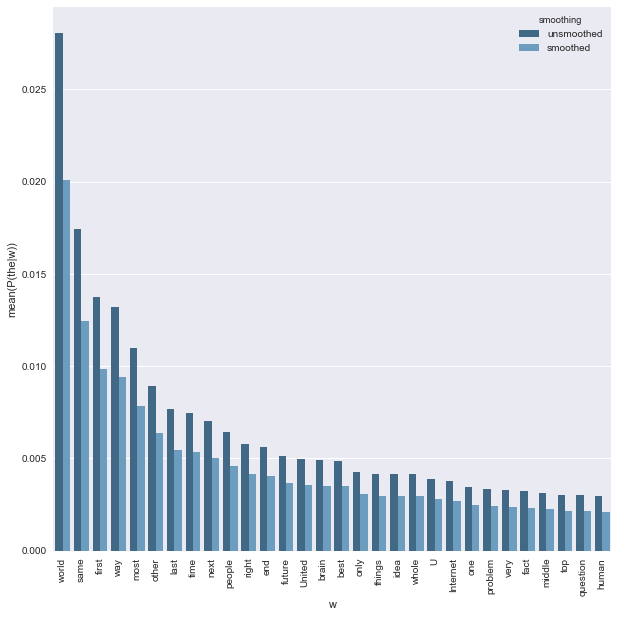

In [271]:
plot_bigram_dist("the", bigram, smoothbigram)

# Explain the difference between the two based on the raw counts of w
print(sum(rawcounts['the'].values()))

In [ ]:
plot_bigram_dist("York", bigram, smoothbigram)

# Explain the difference between the two based on the raw counts of w.
print(sum(rawcounts['York'].values()))
print('total probability smoothed: ',sum(smoothbigram.values()))

In [190]:
smoothbigramsmall, smoothunigramsmall, smoothrawcountssmall = train_ngram(data,2,0.001)

In [ ]:
plot_bigram_dist("the", bigram, smoothbigramsmall)


In [ ]:
plot_bigram_dist("York", bigram, smoothbigramsmall)

**(a)** Use this function to plot the distribution for at least two words `w` and answer the questions
* What is the effect of smoothing on the bigram distribution of frequent words? 

Smoothing is 'stealing from the rich and redistributing to the poor'. 'the' Is a frequent token/word. The probabilities are smaller for the smoothed version than for the unsmoothed version, so that makes sense.


* What is the effect in the case of infrequent words?

'York' is an infrequent token/word. The probabilities for the smoothed version are a lot smaller than for the unsmoothed version. The difference is larger than for the frequent token, this also makes sense. Since everything that will be redistributed must come from the the top most frequent tokens ('City', ',' , 'Times', etc.) Since there are a lot of unseen words.



* Explain the difference between the two based on the raw counts of `w` 

Raw counts the: 195064

Raw counts York: 759

TODO: explain


**(b)** Now experiment with $k$ much smaller than 1 (but greater than 0!) 
* What are the effects?

For both the mean probability of the smoothed version goes up a lot compared to the unsmoothed version







**Recall** that if we have a sentence $w_1,\dots,w_n$ we can write

$$P(w_1\dots w_n) = P(w_1)P(w_2|w_1) \cdots P(w_i|w_1 \dots w_{n-1}) \approx P(w_1)P(w_2|w_1)\cdots P(w_{N-1}|w_1\dots w_{N-2})\prod_{i=N}^{n} P(w_i|w_{i-(N-1)}\dots w_{i-1})$$

where in the last step we make an $N$-gram approximation of the full conditionals.

For example, in the case of a bigram (N=2), the above expression reduces to

$$P(w_1 \dots w_n)\approx P(w_1)\prod_{i=2}^{n} P(w_i| w_{i-1}).$$

## Exercise 2.4 (5 points)

The following sentences are taken from the **training data**. Use your **unsmoothed unigram**, **bigram**, and **trigram** language model to estimate their **probabilities**:

    1. Every day was about creating something new .
    2. In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought 
       together in a collision , producing a burst of pure energy .

**Repeat** this with the **smoothed (add-1)** versions of the N-grams. What is the effect of smoothing on the probabilities?


In [ ]:
# TODO: train on all data
smoothtrigram, smoothunigram, smoothtrirawcounts = train_ngram(data,3,1)

In [281]:
def estimate_probability(sentence, model ,n):
    prob = 1.0
    
    history = deque((n-1)*["<s>"], (n-1))

    for word in sentence:
        
        history_string = ' '.join(history)
        
        # unigram
        if n == 1:
            prob *= model[word]
            
        # bigram or higher
        if n > 1:
            prob *= model[history_string][word]
            print(word,"given history:", history_string, ' has prob', model[history_string][word])
        
        history.append(word)
            
    return prob
                

sentence1 = "<s> Every day was about creating something new . </s>".split()
sentence2 = "<s> In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought together in a collision , producing a burst of pure energy . </s>".split()

testsentence = "<s> Here are two reasons companies fail : they only do more of the same , or they only do what 's new . </s>".split()
#TODO: deze zinnen komen uit de training set en zouden dus allemaal een probability > 0 moeten hebben. Echter is dit (nu) 

# print('Using the unsmoothed unigram model, the probability for sentence 1 is: ', estimate_probability(sentence1, unigram, 1))    

# print('Using the unsmoothed bigram model, the probability for sentence 1 is: ', estimate_probability(sentence1, bigram, 2))  

print('Using the unsmoothed trigram model, the probability for testsentenceeeeeeeeeeeeeeeeeeeeeeeee  is: ', estimate_probability(testsentence, trigram, 3))  


# print('Using the unsmoothed unigram model, the probability for sentence 2 is: ', estimate_probability(sentence2, unigram, 1))    

# print('Using the unsmoothed bigram model, the probability for sentence 2 is: ', estimate_probability(sentence2, bigram, 2))
print()
print()
print()

# print('Using the unsmoothed trigram model, the probability for sentence 2 is: ', estimate_probability(sentence2, trigram, 3))  







# print('Using the smoothed bigram model, the probability for sentence 1 is: ', estimate_probability(sentence1, smoothbigram, 2))  

# print('Using the smoothed bigram model, the probability for sentence 1 is: ', estimate_probability(sentence1, smoothtrigram, 3))

# print('Using the smoothed bigram model, the probability for sentence 2 is: ', estimate_probability(sentence2, smoothbigram, 2))  

# print('Using the smoothed bigram model, the probability for sentence 2 is: ', estimate_probability(sentence2, smoothtrigram, 3))  

<s> given history: <s> <s>  has prob 0.5
Here given history: <s> <s>  has prob 0.0005
are given history: <s> Here  has prob 1.0
two given history: Here are  has prob 1.0
reasons given history: are two  has prob 0.5
companies given history: two reasons  has prob 1.0
fail given history: reasons companies  has prob 1.0
: given history: companies fail  has prob 1.0
they given history: fail :  has prob 1.0
only given history: : they  has prob 0.5
do given history: they only  has prob 1.0
more given history: only do  has prob 0.5
of given history: do more  has prob 1.0
the given history: more of  has prob 0.5
same given history: of the  has prob 0.015625
, given history: the same  has prob 0.05263157894736842
or given history: same ,  has prob 1.0
they given history: , or  has prob 0.07142857142857142
only given history: or they  has prob 1.0
do given history: they only  has prob 1.0
what given history: only do  has prob 0.5
's given history: do what  has prob 1.0
new given history: what 's 

YOUR ANSWERS HERE

## Exercise 2.5 (5 points)

The above sentences were taken from the training set, hence they will all have probability greater than 0. The big challenge for our language model are of course with sentence that contain unseen N-grams: if such an N-gram occurs our model immediately assigns the sentence probability zero.

The following three senteces are taken from the **test set** availlable in the file **ted-test.txt**. What probabilities do your smoothed and unsmoothed language models asign in this case?

    1. Because these robots are really safe .
    2. We have sheer nothingness on one side , and we have this vision of a reality that encompasses every 
       conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible 
       reality .

In [ ]:
test1 = "<s> Because these robots are really safe . </s>"
test2 = 

YOUR ANSWERS HERE

### [Optional]

**Optional** What percentage of the sentences in the test set get assigned probability 0 under your smoothed and unsmoothed language models? 

In [ ]:
### ANSWER HERE ###

## Exercise 2.6 (5 points)

**Perplexity** is very frequently used **metric** for evaluating probabilistic models such as language models. The perplexity (sometimes called **PP** for short) of a language model on a sentence is the **inverse probability** of the sentence, **normalized** by the number of words:

$$PP(w_1 \dots w_n) = P(w_1\dots w_n)^{-\frac{1}{n}}.$$

Here we can again approximate $P(w_1 \dots w_n)$ with N-gram probabilities, as above.
Note: $(x_1\cdots x_n)^{-\frac{1}{n}}$ is the **geometric mean** of the numbers $x_1,\dots,x_n$. It is like the (regular) artithmetic mean, but with **products** instead of **sums**. The geometric mean is a more natural choice in the case of *PP* because behind $P(w_1\dots w_n)$ is a series of $n$ products ([more here](https://en.wikipedia.org/wiki/Geometric_mean)).



Compute the perplexity of the training sentences from excercise 2.1. What big difference between the **probabilities** of the sentences and the **perplexities** of the sentences do you notice?

In [243]:
import math

def perplexity(sentence, model, N):
    perp = math.pow(estimate_probability(sentence, model, N), (-1/len(sentence)))
    return perp

# print('the perplexity of: '+str(sentence1)+'\n is:'+str(perplexity(sentence1, bigram,2)) )
# Error komt omdat de probability nog 0 is bij die bigram probability calculation
print(perplexity(sentence1, bigram,2))

ValueError: math domain error

YOUR ANSWER HERE

# That's it!

Congratulations, you have made it to the end of the tutorial. Here we will recap the gist of this notebook. 

**Make sure all your cells can be executed and all your answers are there. Then, read on if you're interested!**

-----

By now you should have a solid feeling for the problem of **sparsity in language data**; there's just never enough data. For the task of language modelling, we saw that sparsity is a serious challenge. 

It would be great to be able to model $p(w_n|w_1 \dots w_{n-1})$ for unlimited $n$: the larger $n$ the better our language model should become at capturing the long-range dependencies between words that characterize actual human sentences, and the more probability our model will asign to such sentences as opposed to sentences that are word-soup. But in the N-gram approach, increasing $n$ will quickly kill all generalizing abilities of the model: the model will start to asign probabilities only to sentences it has seen in the training data.

So, where to go from here? Here are three directions that we could head in.

### Smoothing

We have seen one example of smoothing in this lab: add-k smoothing. This is an easy method, both conceptually and implementation-wise. But the results are not great, and the effects it has on the distributions can be extreme.

A much more sophisticated method of smoothing is so-called **Kneser-Ney smoothing**. The method is described in detail in section 4.5 of J&M (3rd edition). This is one of the best performing N-gram smoothing methods, and up to a few years ago a popular implementation of it called [KenLM](https://kheafield.com/code/kenlm/) gave state of the art results.

### From words to characters

In this lab we have considered language modeling as the task of predicting a **word** $w_n$ based on a history of **words** $w_1\cdots w_n$. What if instead we let our basic units of modelling be **characters**? The task then becomes to model $p(c_k\mid c_{k-N-1}\dots c_{k-1})$ where each $c_i$ is now an ASCII character instead of an entire word.

Suddenly sparsity of data is no longer a problem! The set of characters to use is tiny (< 100) compared to even a small-sized vocabulary as today. Have a look at this very illustrative notebook written by Yoav Golberg to see such a method in action: [The unreasonable effectiveness of Character-level Language Models](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139).

(So what is the downside?)


### Neural language models

The above notebook was actually written as a response to this blog post by Andrej Karpathy: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Go ahead and read it if you haven't already: it is a superb introduction to the topic of Recurrent Neural Networks.

Neural language models solve the problem of data sparsity in a different manner. Instead of estimating the probabilities $p(w_k\mid w_{k-N-1}\dots w_{k-1})$ by counting occurences in the data, they use a neural network $f_{\theta}$ parametrized by parameters $\theta$ to predict this probability. The parameters $\theta$ are learned through optimization. 

The simplest approach goes like this: each word in the history $w_{k-N-1}\dots w_{k-1}$ is embedded separately giving  vectors $e_{k-N-1}\dots e_{k-1}$ and then concatenated into one long vectors $[e_{k-N-1};\dots ;e_{k-1}]$. The network then uses this history vector to predict a probability distribution over words $w$ in the vocabulary $V$:

$$p(w \mid w_{k-N-1}\dots w_{k-1}) = f_{\theta}([e_{k-N-1};\dots;e_{k-1}]).$$

(In order to produce legitimate probabilities the final layer of such a network will be for example a $softmax$.)

This provides a solution to the sparsity problem by having the network let the individual embeddings of the words in the history interact through its non-linear transforamtion. We are letting the network figure out the smoothing itself!

RNNs are a clever extension of this idea, where a hidden state vector $h$ is re-used and updated at each step $k$ in order to store the information of the entire history up to step $k-1$. That is, an RNN actually does away with the N-order approximation; it tries to model the full conditional directly! That means that

$$p(w \mid w_1\dots w_{k-1}) \approx RNN_{\theta}([e_{k-1};h_{k-1}])$$

where the hidden state $h_{k-1}$ is a compression of the *entire history* $w_1\dots w_{k-1}$.

Another great place to learn about RNNs, their problems, and solutions to those, is on the blog of [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). The project on language modelling will involve learning more about these methods. 

-----------
(And now, it's time to read the classic essay by Eugene Wigner that gave both of the posts their title: [The Unreasonable Effectiveness of Mathematics in the Natural Sciences](http://www.dartmouth.edu/~matc/MathDrama/reading/Wigner.html))